In [6]:
from __future__ import print_function
import os; os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Concatenate
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Input
from keras import backend as K
from keras.models import load_model
import pickle
import pandas as pd
import re
import numpy as np
import random
from keras.utils.vis_utils import plot_model
import keras.callbacks
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn import datasets, linear_model
import seaborn as sns
import pydotplus
#from numpy.random import seed; seed(123)
#import tensorflow as tf; tf.random.set_seed(123)
from sklearn.metrics import roc_auc_score
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import kruskal
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz, DecisionTreeRegressor
import umap
from matplotlib.patches import Rectangle


In [7]:
##### load data #####
processed_data = pickle.load( open( "result_04_processed_data_no_scale_Final.obj", "rb" ) )
cytof_files = processed_data["cytof_files"]
cytof_files.to_csv("result_05_cytof_files.csv")
expr_list = processed_data["expr_list"]
markerNames = processed_data["marker_names"]

r1 = [t1==t1 for t1 in cytof_files.CMV_Ab] 
cytof_files = cytof_files.loc[r1,:]
expr_list = expr_list[r1]
print(expr_list.shape)

y = cytof_files.CMV_Ab.values> 2
x = expr_list

(532, 10000, 27, 1)


In [8]:
##### split train, validation and test######

train_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i] not in ["SDY515","SDY519"]]
valid_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i]=="SDY515"]
test_id = [i for i in range(len(x)) if cytof_files.study_accession.iloc[i]=="SDY519"]

x_train = x[train_id]
x_valid = x[valid_id]
x_test = x[test_id]

y_train = y[train_id]
y_valid = y[valid_id]
y_test = y[test_id]

In [4]:
best_model = load_model("result_05_weights_final.hdf5")
dY = np.zeros([x_test.shape[0],x_test.shape[1]])
s1 = np.random.randint(0,(x_test.shape[1]-1),int(x_test.shape[1]*0.05))

for i2 in range(x_test.shape[0]):
    pred_i2 = best_model.predict([x_test[[i2],:,:,:]])
    for j in range(x_test.shape[1]):
        t1 = x_test[[i2],:,:,:].copy()
        t1[:,s1,:,:] = t1[:,j,:,:]
        pred_j = best_model.predict([t1])
        #dY[i2,j] = pred_j-pred_i2
        dY[i2,j] = 1/(1+np.exp(-pred_j)) - 1/(1+np.exp(-pred_i2))

dY = dY.reshape([x_test.shape[0]*x_test.shape[1]])
    
with open("result_16_dY_linear.obj", "wb") as f:
    pickle.dump(dY, f)

In [5]:
dY = pickle.load( open( "result_16_dY_linear.obj", "rb" ) )
x_test2 = x_test.reshape((x_test.shape[0]*x_test.shape[1],27))
s1 = np.random.randint(0,(dY.shape[0]-1),30000)
x_test2 = x_test2[s1]
dY = dY[s1]

In [6]:
X_embedded = TSNE(n_components=2,perplexity=30).fit_transform(x_test2)

order = dY.argsort()
ranks = order.argsort()

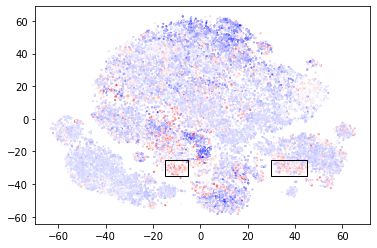

In [27]:
plt.scatter(x=X_embedded[:,0], y =X_embedded[:,1],s = 1, cmap=cm,
            c = dY)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((-15, -35), 10, 10, facecolor="black",fill=False))
currentAxis.add_patch(Rectangle((30, -35), 15, 10, facecolor="black",fill=False))

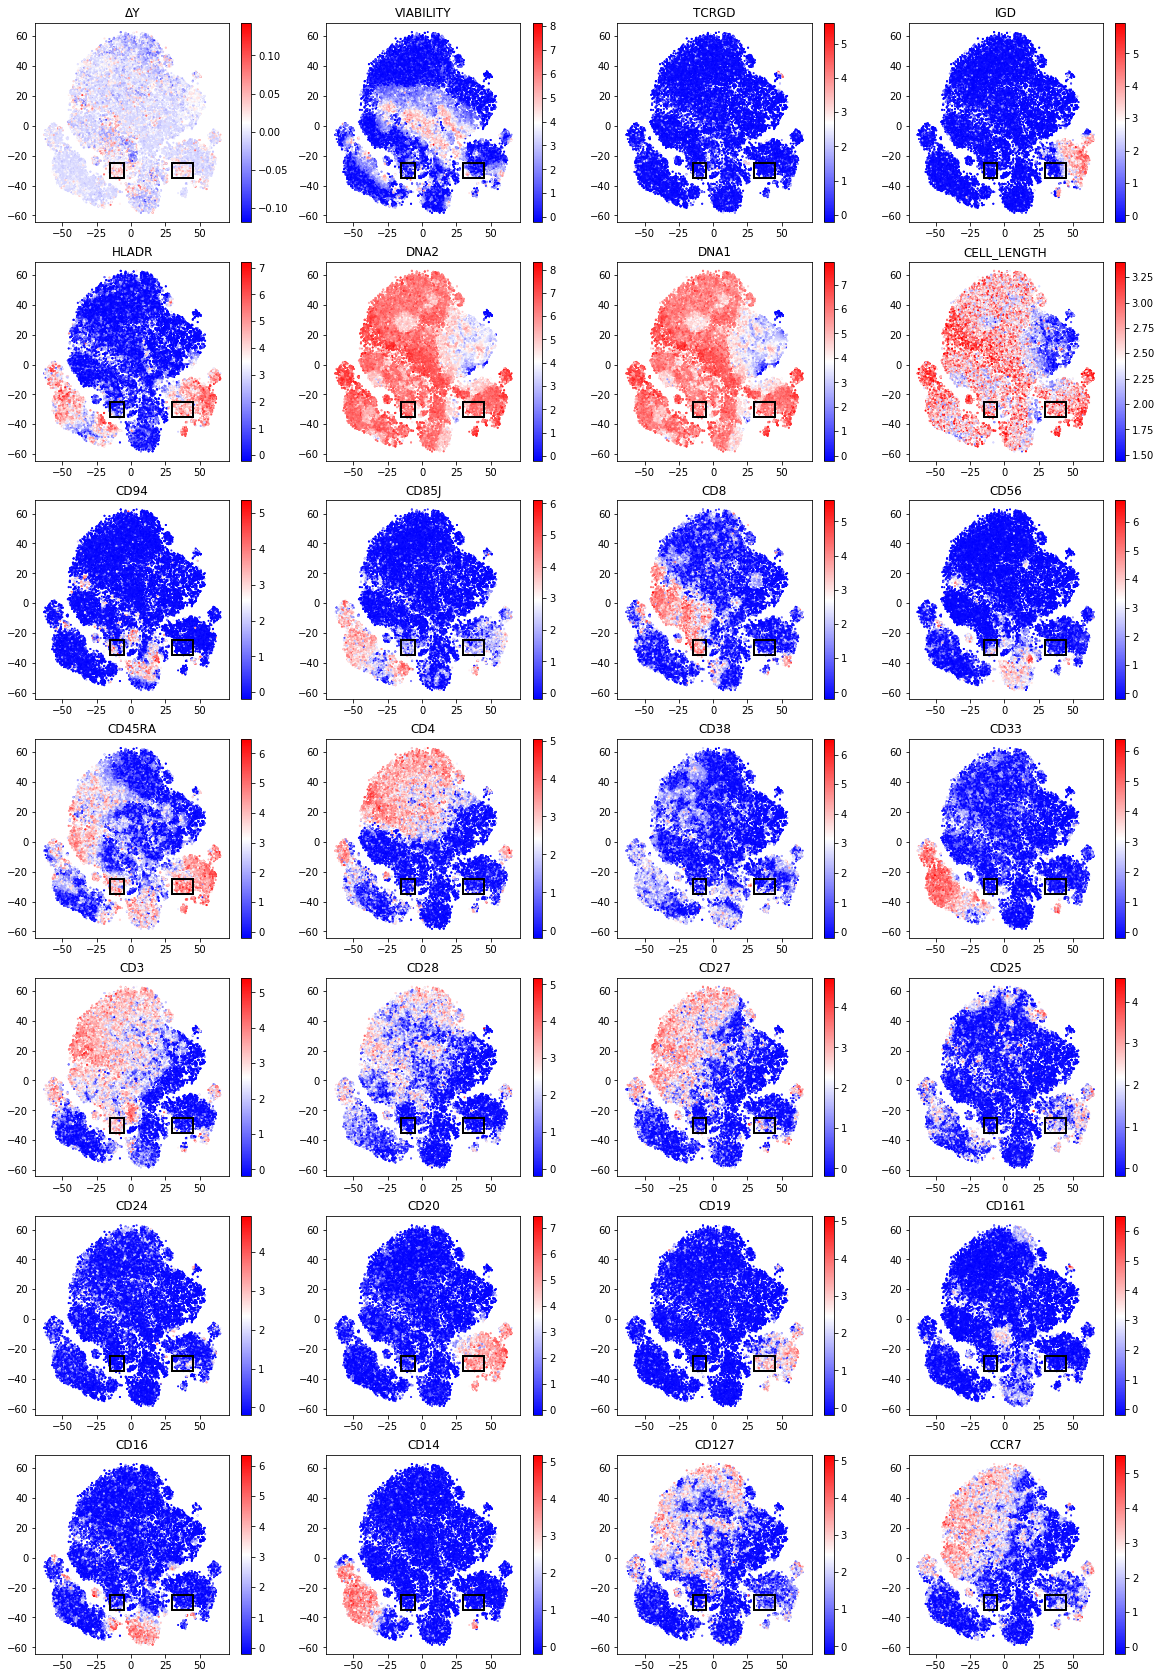

In [31]:
cm = plt.cm.get_cmap('bwr')

f = plt.figure(figsize=(20,30))

plt.subplot(7,4,1)
plt.scatter(x=X_embedded[:,0], y =X_embedded[:,1],s = 1, cmap=cm,
            c = dY)
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((-15, -35), 10, 10, facecolor="black",fill=False,lw = 2))
currentAxis.add_patch(Rectangle((30, -35), 15, 10, facecolor="black",fill=False,lw = 2))
plt.colorbar()
plt.title("ΔY")


for i in range(0,x_test2.shape[1]):
    plt.subplot(7,4,i+2)
    plt.scatter(x=X_embedded[:,0], y =X_embedded[:,1],s = 1, cmap=cm,
            c = x_test2[:,i])
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((-15, -35), 10, 10, facecolor="black",fill=False,lw = 2))
    currentAxis.add_patch(Rectangle((30, -35), 15, 10, facecolor="black",fill=False,lw = 2))
    plt.colorbar()
    plt.title(markerNames[i])
    
plt.show()
f.savefig("result_16_tsne.png", bbox_inches='tight',format="png",dpi = 300)
